# ${\textbf{Customer Analytics - Segmentation}}$

##### ${\textbf{Welcome to my Customer analytics project!}}$
##### ${\textbf{In this workbook we will perform customer segmentation with two different kind of clustering algorithms!}}$
##### ${\textbf{The models and scaler created in this workbook will be saved with pickle and applied to new data}}$





### ${\textbf{Loading Libraries}}$

In [3]:
#Let's start with importing the necessary libraries as always
import numpy as np
import pandas as pd

import scipy
from scipy.cluster.hierarchy import dendrogram, linkage

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

import pickle

### ${\textbf{Import and Explore Data}}$

#### ${\textbf{Note: This time the dataset we will be working with has already been preprocessed for the sake of simplicity}}$

In [4]:
#Loading dataset:
df_dataset = pd.read_csv('segmentation data.csv', index_col = 0)

In [5]:
#Let's take a quick look on the first 10 rows of data to make sure we loaded everything correctly
df_dataset.head(10)

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
ID,,,,,,,
100000001,0,0,67,2,124670,1,2
100000002,1,1,22,1,150773,1,2
100000003,0,0,49,1,89210,0,0
100000004,0,0,45,1,171565,1,1
100000005,0,0,53,1,149031,1,1
100000006,0,0,35,1,144848,0,0
100000007,0,0,53,1,156495,1,1
100000008,0,0,35,1,193621,2,1
100000009,0,1,61,2,151591,0,0


In [6]:
#Creating a quick summary table about the values of df_dataset
def sumtab(df): 

    types = df.dtypes
    count = df.apply(lambda x: x.count())
    null = df.apply(lambda x: x.isnull().sum())
    distinct = df.apply(lambda x: x.unique().shape[0])
    skew = df.skew()
    
    table = pd.concat([types, count, null, distinct, skew], axis = 1, sort=True)
    table.columns = [ 'Type', 'Counts', 'Nulls', 'N distinct values', 'Skewness']
    
    return table

sumtab(df_dataset)

#As we can see below there are no missing values in the dataset, we have 5 categorical variables 
# and 2 continous variables that are fairly skewed to the left

,Type,Counts,Nulls,N distinct values,Skewness
Age,int64,2000,0,58,1.009940
Education,int64,2000,0,4,0.487172
Income,int64,2000,0,1982,1.196085
Marital status,int64,2000,0,2,0.014011
Occupation,int64,2000,0,3,0.188522
Settlement size,int64,2000,0,3,0.510541
Sex,int64,2000,0,2,0.172769


In [7]:
#Let's get some additional insight on the data by looking at mean and standard deviation
df_dataset.describe()

#As we can see below the dataset appears normal and there are no extreme outliers either

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
count,2000.000000,2000.000000,2000.000000,2000.00000,2000.000000,2000.000000,2000.000000
mean,0.457000,0.496500,35.909000,1.03800,120954.419000,0.810500,0.739000
std,0.498272,0.500113,11.719402,0.59978,38108.824679,0.638587,0.812533
min,0.000000,0.000000,18.000000,0.00000,35832.000000,0.000000,0.000000
25%,0.000000,0.000000,27.000000,1.00000,97663.250000,0.000000,0.000000
50%,0.000000,0.000000,33.000000,1.00000,115548.500000,1.000000,1.000000
75%,1.000000,1.000000,42.000000,1.00000,138072.250000,1.000000,1.000000
max,1.000000,1.000000,76.000000,3.00000,309364.000000,2.000000,2.000000


### ${\textbf{Correlation Estimation}}$

In [8]:
#Let's see the correlation between the variables
df_dataset.corr()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
Sex,1.000000,0.566511,-0.182885,0.244838,-0.195146,-0.202491,-0.300803
Marital status,0.566511,1.000000,-0.213178,0.374017,-0.073528,-0.029490,-0.097041
Age,-0.182885,-0.213178,1.000000,0.654605,0.340610,0.108388,0.119751
Education,0.244838,0.374017,0.654605,1.000000,0.233459,0.064524,0.034732
Income,-0.195146,-0.073528,0.340610,0.233459,1.000000,0.680357,0.490881
Occupation,-0.202491,-0.029490,0.108388,0.064524,0.680357,1.000000,0.571795
Settlement size,-0.300803,-0.097041,0.119751,0.034732,0.490881,0.571795,1.000000


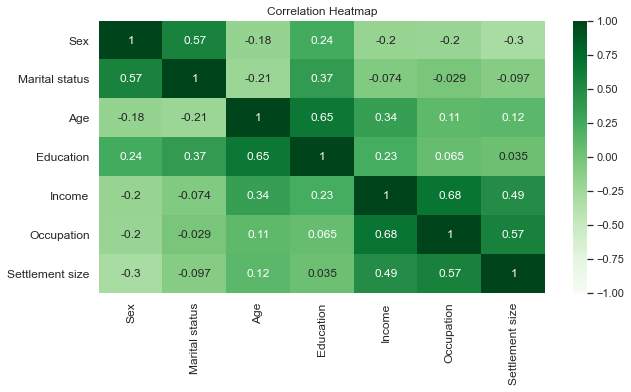

In [9]:
#To make it easier on the eye let's plot it on a heatmap
plt.figure(figsize = (10, 5))
s = sns.heatmap(df_dataset.corr(),
               annot = True, 
               cmap = 'Greens',
               vmin = -1, 
               vmax = 1)
s.set_yticklabels(s.get_yticklabels(), rotation = 0, fontsize = 12)
s.set_xticklabels(s.get_xticklabels(), rotation = 90, fontsize = 12)
plt.title('Correlation Heatmap')
plt.show()

### ${\textbf{Standardization}}$

In [10]:
#Before we employ a clustering algorithm we have to standardize the dataset to equalize the range of the variables:
scaler = StandardScaler()
std_dataset = scaler.fit_transform(df_dataset)

### ${\textbf{Method 1 - Hierarchical Clustering}}$

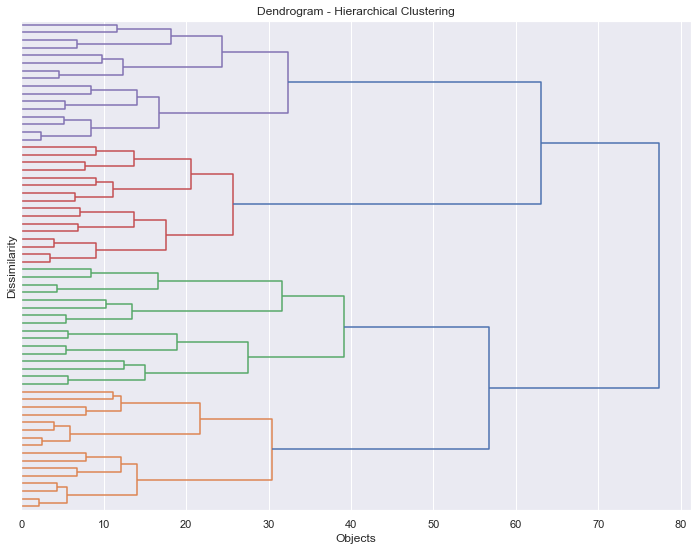

In [11]:
#Setting up a hierachical model doesn't take much time:
hier_clust = linkage(std_dataset, method = 'ward')

#Plotting hierachical model as a dendrogram
plt.figure(figsize = (12,9))
plt.title('Dendrogram - Hierarchical Clustering')
plt.xlabel('Objects')
plt.ylabel('Dissimilarity')
dendrogram(hier_clust,
           truncate_mode = 'level',
           orientation='right',
           p = 5,
           show_leaf_counts = False,
           no_labels = True)
plt.show()

#As we can see below hierarchical clustering resulted in 4 groups for our dataset  

### ${\textbf{Method 2 - Flat Clustering (K-means)}}$

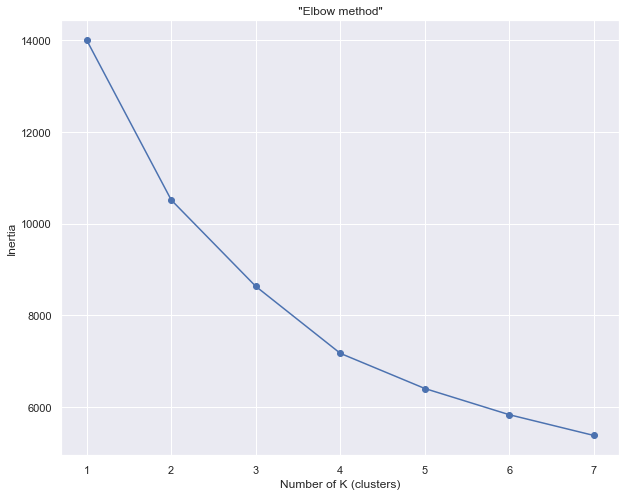

In [12]:
#Now let's see how many clusters the 'elbow method' yield:

#Create a list with respective 'within cluster sum of squares' values for each number of clusters (K= 1-8 should do in our case)
inertia = []
for i in range(1,8):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(std_dataset)
    inertia.append(kmeans.inertia_)

#Plot the inertia aginst the respective K value
plt.figure(figsize = (10,8))
plt.plot(range(1, 8), inertia, marker = 'o', linestyle = '-')
plt.xlabel('Number of K (clusters)')
plt.ylabel('Inertia')
plt.title(' "Elbow method" ')
plt.show()

#Looking at the graph below we can see that increasing the number of clusters after K=4 doesn't decrease the within cluster
# sum of squares significantly so we go with K=4 as an assumed best solution regarding the number of clusters. Our results 
# coincide with the result of our dendogram above which also resulted in 4 clusters

### ${\textbf{Fitting the model}}$

In [13]:
#Now we are going to fit our model using 4 clusters on our standardized dataset
kmeans_model = KMeans(n_clusters = 4, init = 'k-means++', random_state = 42)
kmeans_model.fit(std_dataset)

KMeans(n_clusters=4, random_state=42)

### ${\textbf{Results}}$

In [14]:
#
df_dataset_kmeans = df_dataset.copy()
df_dataset_kmeans['Segment K-means'] = kmeans_model.labels_

In [15]:
df_segm_analysis = df_dataset_kmeans.groupby(['Segment K-means']).mean()

In [16]:
df_segm_analysis['N Obs'] = df_dataset_kmeans[['Segment K-means','Sex']].groupby(['Segment K-means']).count()
df_segm_analysis['Prop Obs'] = df_segm_analysis['N Obs'] / df_segm_analysis['N Obs'].sum()
df_segm_analysis

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,N Obs,Prop Obs
Segment K-means,,,,,,,,,
0,0.501901,0.692015,55.703422,2.129278,158338.422053,1.129278,1.110266,263,0.1315
1,0.352814,0.019481,35.577922,0.746753,97859.852814,0.329004,0.043290,462,0.2310
2,0.029825,0.173684,35.635088,0.733333,141218.249123,1.271930,1.522807,570,0.2850
3,0.853901,0.997163,28.963121,1.068085,105759.119149,0.634043,0.422695,705,0.3525


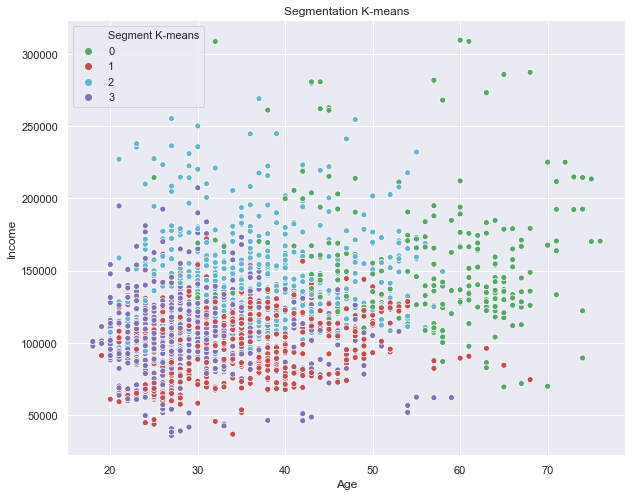

In [17]:
x_axis = df_dataset_kmeans['Age']
y_axis = df_dataset_kmeans['Income']
plt.figure(figsize = (10, 8))
sns.scatterplot(x_axis, y_axis, hue = df_dataset_kmeans['Segment K-means'], palette = ['g', 'r', 'c', 'm'])
plt.title('Segmentation K-means')
plt.show()

# ${\textbf{SECOND HALF UPLOADED TOMORRROW (SEP 25)}}$